<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор,-подготовка-и-ресемплирование-данных" data-toc-modified-id="Обзор,-подготовка-и-ресемплирование-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор, подготовка и ресемплирование данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-и-ресемплирование-данных" data-toc-modified-id="Предобработка-и-ресемплирование-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка и ресемплирование данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Регрессия-ElasticNet" data-toc-modified-id="Регрессия-ElasticNet-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Регрессия ElasticNet</a></span></li><li><span><a href="#Метод-опорных-векторов-SVM" data-toc-modified-id="Метод-опорных-векторов-SVM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Метод опорных векторов SVM</a></span></li><li><span><a href="#Ансамбль-линейных-моделей" data-toc-modified-id="Ансамбль-линейных-моделей-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Ансамбль линейных моделей</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#XGB" data-toc-modified-id="XGB-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>XGB</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Иcходные данные**

Компания предоставляющая услуги такси собрала исторические данные о заказах такси в аэропортах. 

**Цель исследования**

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Метрика качества *RMSE* на тестовой выборке должно быть не больше 48.


**Ход исследования**

1. Обзор, подготовка и ресемплирование данных по одному часу.
2. Анализ данных.
3. Обучение и проверка различных моделей.
4. Финальное тестирование лучшей модели.
5. Вывод.

## Обзор, подготовка и ресемплирование данных

### Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xgboost as xgb

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

### Обзор данных

In [2]:
#загрузим данные

pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Файл не найден!')

In [3]:
# выполним первичный обзор
print(taxi.info())
display(taxi.head(10))
print(f'Данные представлены за период наблюдений с {taxi.index.min()} по {taxi.index.max()}')
print('Упорядочены ли данные:', taxi.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Данные представлены за период наблюдений с 2018-03-01 00:00:00 по 2018-08-31 23:50:00
Упорядочены ли данные: True


В таблице 26496 наблюдений с 1ого марта по 31ое августа с разницей 10 минут.
Согласно документации количество заказов находится в столбце `num_orders`.

Имеет смысл:
1. Поменять тип данных с int64 на мениший.
2. Проверить данные на пропуски, аномалии и дубликаты.

### Предобработка и ресемплирование данных

Приверим данные на дублекаты по индексам.

In [4]:
taxi.index.duplicated().sum()

0

Судя по минимальному и максимальному значениям анаомалий нет. Проверим пропуски.

In [5]:
taxi['num_orders'].isna().sum()

0

Не обнаружено. Проведем ресемплирование по одному часу. Нас интересует общее число заказов.

In [6]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Определим и изменим тип данных `num_orders`.

In [7]:
# посмотрим максимальное и минимальное значения
print(f"Заначения num_orders лежат в диапазоне от {taxi['num_orders'].min()} до {taxi['num_orders'].max()}.")

Заначения num_orders лежат в диапазоне от 0 до 462.


Нам подходит uint8.

In [8]:
taxi['num_orders'] = np.uint8(taxi['num_orders'])

# проверим
taxi['num_orders'].dtypes

dtype('uint8')

Данные готовы к дальнейшей работе.

## Анализ данных

Построим график разпределения заказов.

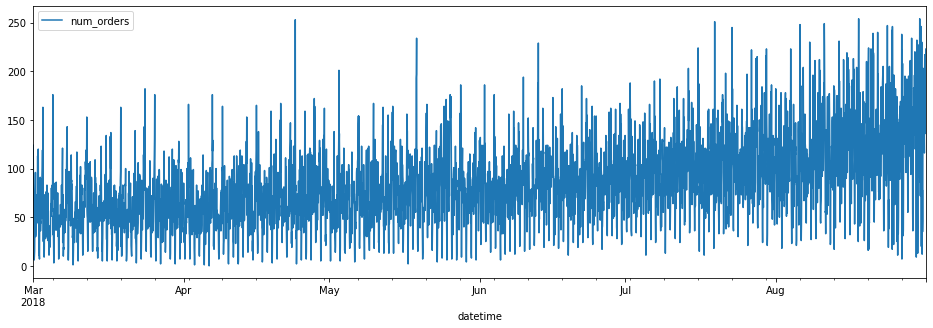

In [9]:
taxi.plot(figsize=(16, 5));

Мало, что понятно. Видно только, что стандартное отклонение увеличивается и, предположительно растет среднее.

Если разбить данные на интервалы по 8 часов, должно быть видно лучше, при этом сохранятся ночные и дневные заказы. Окно выберем размером 3 (одни сутки).

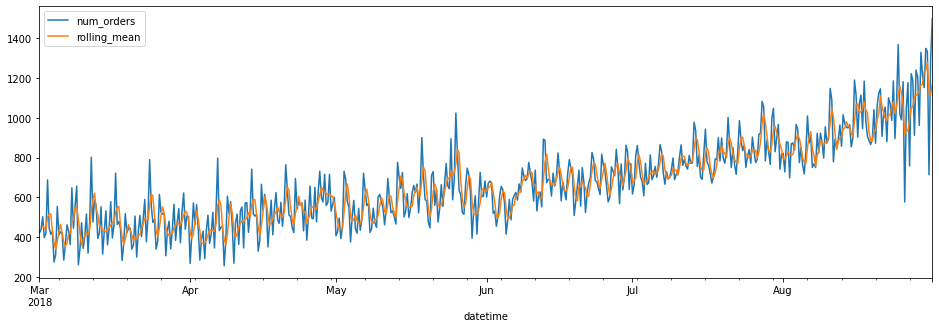

In [10]:
taxi_8h = taxi.resample('8H').sum()
taxi_8h['rolling_mean'] = taxi_8h.rolling(3).mean()
taxi_8h.plot(figsize=(16, 5));

Видим, что с марта по май особых изменений не наблюдалось, зато с середины мая до конца августа число заказов в среднем растет. Силенее всего в августе. Похоже на сезонный рост связанный с возвращением из отпусков к 1 сентября. Однако проверить это мы не сможем, т.к. данных за другие годы нет.

Можем оценить изменения по ночным и дневным заказам, а также тренды и сезонность на исходном датасете.

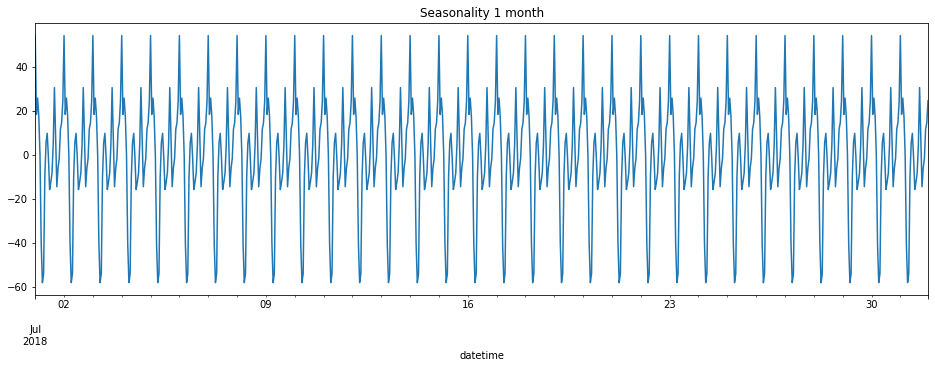

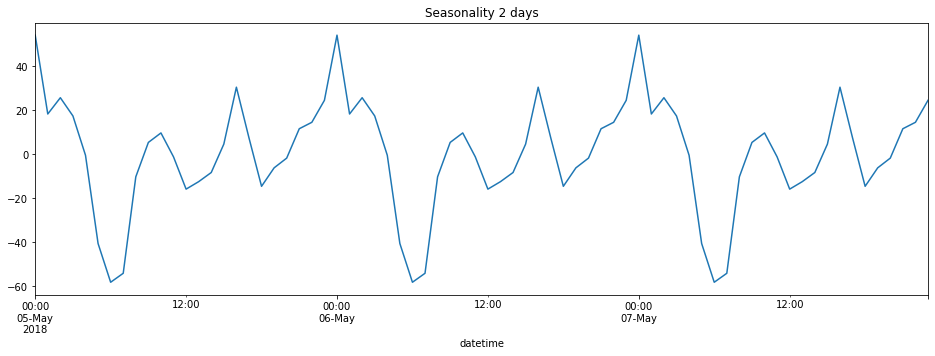

In [11]:
# посмотрим сезоны периоде за 1 месяц (май)
taxi_decomposit = seasonal_decompose(taxi)


taxi_decomposit.seasonal['2018-07':'2018-07'].plot(figsize=(16, 5));
plt.title('Seasonality 1 month');
plt.show()

# и за 1 сутки
taxi_decomposit.seasonal['2018-05-05':'2018-05-07'].plot(figsize=(16, 5));
plt.title('Seasonality 2 days');
plt.show()

Можем заметить, что минимальное количество заказов наблюдается ежедневно около 6 часов утра. Максимальное - ближе к 12 ночи. От месяца к месяцу значительных изменений не наблюдается.

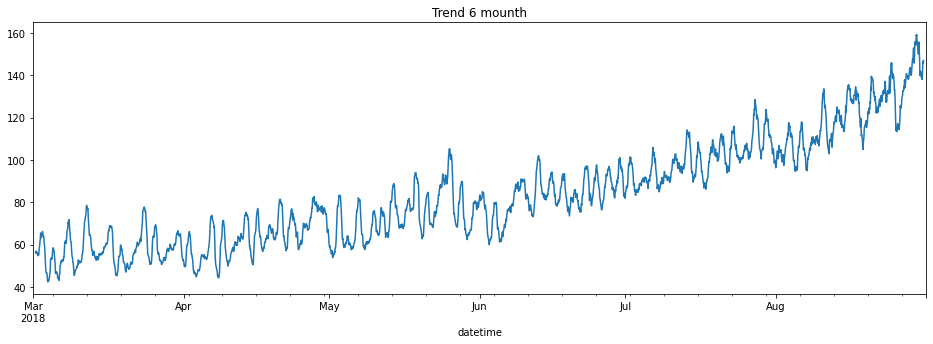

In [12]:
# посмотрим тренд за весь период
taxi_decomposit.trend.plot(figsize=(16, 5));
plt.title('Trend 6 mounth');
plt.show()

Снова видим, что хотя внутри периодов число заказов то падает, то растет, общий тренд на увеличение.

Посмотрим на табличных данных.

,num_orders
datetime,
2018-03-31,57.483871
2018-04-30,63.804167
2018-05-31,73.682796
2018-06-30,83.202778
2018-07-31,100.006720
2018-08-31,122.146505


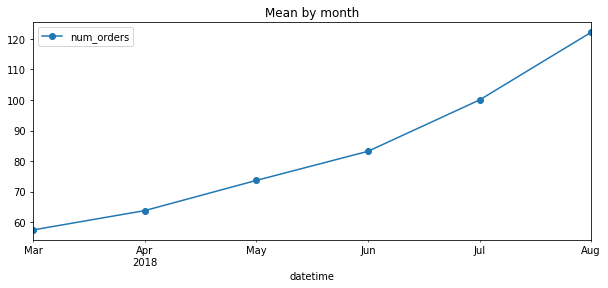

In [13]:
month_mean = taxi.resample('1M').mean()
display(month_mean)
month_mean.plot(figsize=(10, 4), title='Mean by month', marker='o');

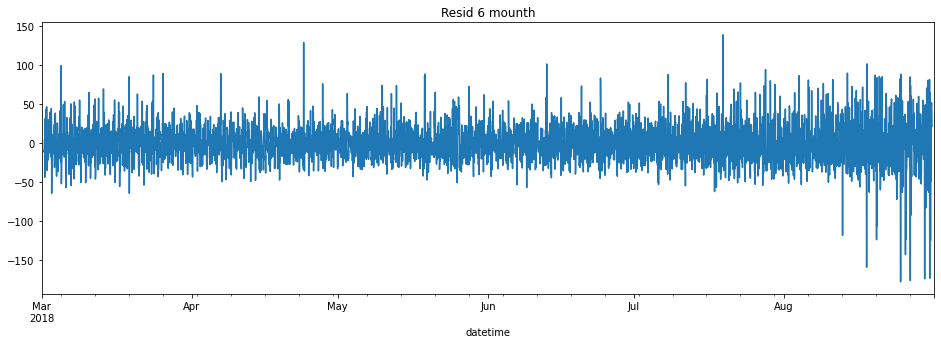

In [14]:
# оченим шумы
taxi_decomposit.resid.plot(figsize=(16, 5));
plt.title('Resid 6 mounth');
plt.show()

Можем отметить увеличение количества шумов в конце периода.

## Подготовка выборок

Добавим в датасет признаки, разделим данные на тренировочную и тестовую выборки.

In [15]:
# создадим функцию для добавления признаков с разными параметрами

def make_features(data, lag_qty, win_size): 
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, lag_qty+1):
        data['lad_' + str(i)] = data.iloc[:, 0].shift(i)
        
    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(win_size).mean()

In [16]:
make_features(taxi, 8, 24)
taxi = taxi.dropna()

taxi.head()

,num_orders,month,day,dayofweek,hour,lad_1,lad_2,lad_3,lad_4,lad_5,lad_6,lad_7,lad_8,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,56.958333


Отделим целевой признак и разделим выборку.

In [17]:
features = taxi.drop('num_orders', axis=1)
target = taxi['num_orders']

Мы будем использовать кросс-валидацию, поэтому валидационная выборка не потребуется.

In [18]:
# отделим тестовую выборку

train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                            target, 
                                                                            shuffle=False, 
                                                                            test_size=0.1
                                                                           )

Проверим размер и упорядоченность выборок.

In [19]:
print(f'Тествая выборка составляет {test_features.shape[0]/features.shape[0]:.0%} от исходного датасета')

if (train_features.index.max() < test_features.index.min()):
    print('Последовательность данных сохранена.')
else:
    print('Последовательность данных нарушена!')

Тествая выборка составляет 10% от исходного датасета
Последовательность данных сохранена.


Можно переходить к обучению моделей.

## Обучение моделей

Обучим следующие модели:

1. ElasticNet
2. SVM
3. Ансамбль линейных моделей
4. RandomForestRegressor
5. CatBoost
6. XGB

### Регрессия ElasticNet

In [20]:
%%time

# создадим общий для всех моделей кросс-валидатор
tscv = TimeSeriesSplit(n_splits=9, gap=0)

parametrs_en ={'l1_ratio': np.arange(0.1, 1.1, 0.1),
               'max_iter': range(100, 501, 100)
              }

gs_en = GridSearchCV(ElasticNet(random_state=42), 
                     parametrs_en, 
                     scoring='neg_root_mean_squared_error', 
                     n_jobs=-1, 
                     cv=tscv
                    )
gs_en.fit(train_features, train_target)

model_en = gs_en.best_estimator_
score_en = abs(gs_en.best_score_)

print(f'RMSE ElasticNet на валидационной выборке: {score_en:.2f}')

RMSE ElasticNet на валидационной выборке: 30.92
CPU times: total: 953 ms
Wall time: 5.74 s


Создадим таблицу для сравнения.

In [21]:
# добавим данные ElasticNet

time_sheet = pd.DataFrame(['ElasticNet', score_en], index=['Model', 'RMSE'])

### Метод опорных векторов SVM

In [22]:
%%time

# около 40 секунд

parametrs_svm ={'kernel': ['rbf', 'linear', 'poly'],
                'epsilon': np.arange(0.1, 0.51, 0.1),
               'max_iter':[-1, 50, 100]
              }

gs_svm = GridSearchCV(SVR(), 
                      parametrs_svm, 
                      scoring='neg_root_mean_squared_error', 
                      n_jobs=-1, 
                      cv=tscv
                     )
gs_svm.fit(train_features, train_target)

model_svm = gs_svm.best_estimator_
score_svm = abs(gs_svm.best_score_)

print(f'RMSE SVR на валидационной выборке: {score_svm:.2f}')

RMSE SVR на валидационной выборке: 31.01
CPU times: total: 2.38 s
Wall time: 1min 51s


In [23]:
# добавим данные SVR 

time_sheet[1] = ['SVR', score_svm]

### Ансамбль линейных моделей

In [24]:
%%time

parametrs_br ={'base_estimator': [LinearRegression(), Ridge(), Lasso()],
                'n_estimators': range(5, 101, 10),
                'bootstrap':['True', 'False']
              }

gs_br = GridSearchCV(BaggingRegressor(random_state=42), 
                     parametrs_br, scoring='neg_root_mean_squared_error', 
                     n_jobs=-1, 
                     cv=tscv
                    )
gs_br.fit(train_features, train_target)

model_br = gs_br.best_estimator_
score_br = abs(gs_br.best_score_)

print(f'RMSE BaggingRegressor на валидационной выборке: {score_br:.2f}')

RMSE BaggingRegressor на валидационной выборке: 30.81
CPU times: total: 2.17 s
Wall time: 22.3 s


In [25]:
# добавим данные BaggingRegressor 

time_sheet[2] = ['BaggingRegressor', score_br]

### RandomForestRegressor

In [26]:
%%time

# примерно 2 минуты

parametrs_rf ={'n_estimators': range(5, 121, 15),
               'max_depth': range(1, 21, 3),
               'bootstrap':['True', 'False']
              }

gs_rf = GridSearchCV(RandomForestRegressor(random_state=42), 
                     parametrs_rf, scoring='neg_root_mean_squared_error', 
                     n_jobs=-1, 
                     cv=tscv
                    )
gs_rf.fit(train_features, train_target)

model_rf = gs_rf.best_estimator_
score_rf = abs(gs_rf.best_score_)

print(f'RMSE RandomForestRegressor на валидационной выборке: {score_rf:.2f}')

RMSE RandomForestRegressor на валидационной выборке: 23.67
CPU times: total: 7.69 s
Wall time: 1min 52s


In [27]:
# добавим данные RandomForestRegressor 

time_sheet[3] = ['RandomForestRegressor', score_rf]

###  CatBoostRegressor

In [28]:
%%time 

# примерно 1 минуту

parametrs_cbr = {'depth': range(2, 11, 2),
                 'iterations': range(5, 16, 5),
                 'learning_rate': np.arange(0.1, 0.6, 0.1),
                 'reg_lambda': np.arange(0.1, 0.4, 0.1)
                }

gs_cbr = GridSearchCV(CatBoostRegressor(random_state=42, verbose=False), 
                      parametrs_cbr, scoring='neg_root_mean_squared_error', 
                      n_jobs=-1, 
                      cv=tscv
                     )
gs_cbr.fit(train_features, train_target)

model_cbr = gs_cbr.best_estimator_
score_cbr = abs(gs_cbr.best_score_)

print(f'RMSE CatBoost на валидационной выборке: {score_cbr:.2f}')

RMSE CatBoost на валидационной выборке: 24.99
CPU times: total: 12.6 s
Wall time: 2min 6s


In [29]:
# добавим данные CatBoost 

time_sheet[4] = ['CatBoost', score_cbr]

###  XGB

In [30]:
parametrs_xgb = {'max_depth': range(2, 11, 2),
                 'n_estimators': range(10, 41, 10),
                 'learning_rate': np.arange(0.1, 0.6, 0.1),
                 'reg_alpha': np.arange(0.1, 0.4, 0.1)
                }

gs_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), 
                      parametrs_xgb, scoring='neg_root_mean_squared_error', 
                      n_jobs=-1, 
                      cv=tscv
                     )
gs_xgb.fit(train_features, train_target)

model_xgb = gs_xgb.best_estimator_
score_xgb = abs(gs_xgb.best_score_)

print(f'RMSE XGB на валидационной выборке: {score_xgb:.2f}')

RMSE XGB на валидационной выборке: 24.26


In [31]:
# добавим данные XGB 

time_sheet[5] = ['XGB', score_xgb]

Посмотрим таблицу результатов.

In [32]:
pd.options.display.float_format = '{:.2f}'.format
time_sheet

,0,1,2,3,4,5
Model,ElasticNet,SVR,BaggingRegressor,RandomForestRegressor,CatBoost,XGB
RMSE,30.92,31.01,30.81,23.67,24.99,24.26


RandomForestRegressor лидирует. Проверим ее на тестовой выборке.

## Тестирование

Рассичтаем RMSE лучшей модели на тестовой выборке

In [33]:
best_model_predict = model_rf.predict(test_features)
best_model_score = mean_squared_error(test_target, best_model_predict, squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {best_model_score:.2f}')

RMSE лучшей модели на тестовой выборке: 44.48


Сравним с моделью-пустышкой.

In [34]:
dummy_model = DummyRegressor()
dummy_model.fit(train_features, train_target)
dummy_model_predict = dummy_model.predict(test_features)
dummy_model_score = mean_squared_error(test_target,dummy_model_predict, squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {dummy_model_score:.2f}')

if dummy_model_score > best_model_score:
    print('Модель успешно прошла тестирование.')
else:
    print('Модель никуда не годится!')

RMSE лучшей модели на тестовой выборке: 75.04
Модель успешно прошла тестирование.


Построим график сходимости для предсказаний.

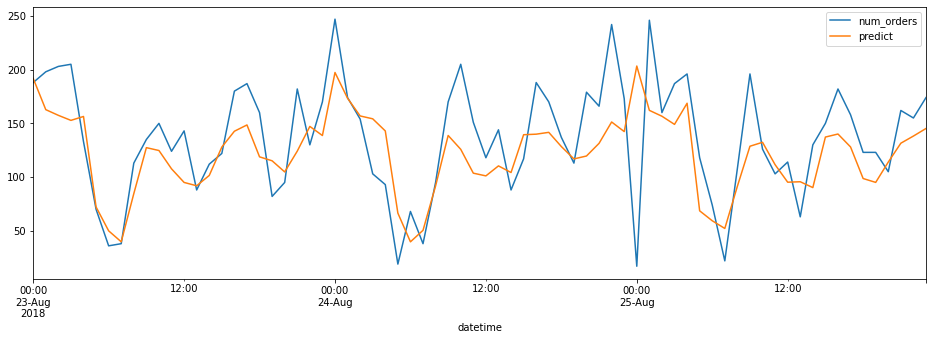

In [35]:
predict_plot = pd.DataFrame(test_target.copy())
predict_plot['predict'] = best_model_predict
predict_plot['2018-08-23':'2018-08-25'].plot(figsize=(16, 5));

По графику видно, что чувствительность к изменению числа заказов очень высокая, но не исключены и вылеты (25.08 00:00).

## Вывод

Мы проанализировали данные за выбранный период, установили сезонную зависимость от времени суток и общий тренд на увеличение числа заказов.

Нам удалось обучить модель с достаточно точными для заказчика предсказаниями. Итоговая метрика RMSE 44.48